In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import gym
from collections import deque
import random
import sys
import pandas as pd
import matplotlib.pyplot as plt
from numpy import cos, sin
from gym import spaces
from gym.error import DependencyNotInstalled
from typing import Optional
from control.matlab import ss, lsim, linspace, c2d
from functools import partial
from state_estimation import Estimator
import math
import gym
from stable_baselines3 import PPO, SAC, TD3, DDPG, DQN, A2C
from stable_baselines3.common.env_checker import check_env
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [8]:
# define CSTR model
def bicycle(x,t,u, params={}):
    lr = 1.105
    lf = 1.738
    psi = x[2]
    v = x[3]
    alpha = u[0]
    sigma = u[1]
    xdot =np.zeros(4)
    beta = math.atan((lr/(lr+lf)*math.tan(sigma)))
    xdot[0] = v*math.cos(psi+beta)
    xdot[1] = v*math.sin(psi+beta)
    xdot[2] = v/lr*math.sin(beta)
    xdot[3] = alpha
    return xdot

In [9]:
class bicycleEnv(gym.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render.modes": ["human"]}

    def __init__(self, render_mode: Optional[str] = None, g=10.0):
        super(bicycleEnv).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        ob_high = np.ones(4)*20
        action_high = np.ones(2)*7
        self.action_space = spaces.Box(low=-action_high, high=action_high, dtype=np.float32)
        self.observation_space = spaces.Box(low=-ob_high, high=ob_high, dtype=np.float32)
        self.step_const = 20
        self.freq = 0.1
        self.steps = 0
        self.center = [1,1,0,math.sqrt(2)]
        self.obstacle = [0.5,0.5,0,math.sqrt(2)/2]
        self.reward_cache = [] # cache distances to target norm ball center
        self.final_reward_cache = [] # cache final reward
        self.state = np.random.rand(4)*2-1
        self.horizon = np.arange(0, self.step_const+2, 1)*0.1
        self.target_norm_radius = 0.8
        self.safe_norm_radius = 0.4
        self.max_reward_list = []
        self.avoid_reward_cache = [] 
        self.quality_list = []
        self.total_steps = 0
        self.step_history = []
        self.k = 20
    def step(self, action):
        terminated = False
        ts = [self.horizon[self.steps], self.horizon[self.steps+1] ]
        self.state = odeint(bicycle, self.state, ts, args=(action,))[-1]
        dist = np.linalg.norm(self.state - self.center)
        obs_dist = np.linalg.norm(self.state - self.obstacle)
        reward = self.target_norm_radius - dist
        obs_reward = obs_dist - self.safe_norm_radius
        # reward = self.target_norm_radius - dist + obs_dist - 0.3
        self.reward_cache.append(reward)
        self.avoid_reward_cache.append(obs_reward)
        if self.steps < 10:
            reach_reward = max(self.reward_cache)
        else:
            reach_reward = max(self.reward_cache[-10:])
        if self.steps < 10:
            avoid_reward = min(self.avoid_reward_cache)
        else:
            avoid_reward = min(self.avoid_reward_cache[-10:])    
        final_reward = min(reach_reward, avoid_reward)
        self.reward_cache.append(reward)
        self.steps += 1
        self.total_steps +=1
        # quantitative semantics
        # reach reward, encourage reaching target
        # if self.steps < 10:
        #     reach_reward = max(self.reward_cache)
        # else:
        #     reach_reward = max(self.reward_cache[-10:])
        # final_reward = reach_reward
        if dist <= self.target_norm_radius:
            final_reward = 10
        self.final_reward_cache.append(final_reward)
        if self.steps == self.step_const or max(np.absolute(self.state))>20 or obs_dist<=self.safe_norm_radius:
            self.max_reward_list.append(max(self.final_reward_cache)) # use max final reward to measure episodes
            self.step_history.append(self.total_steps)
            self.quality_list.append(sum(self.final_reward_cache))
            terminated = True
            self.reset()

        # Return next state, reward, done, info
        return self.state, final_reward, terminated, {}

    def reset(self):
        self.steps = 0
        # self.state = np.random.rand(4)*2-1
        self.state = np.random.rand(4)*2-1.2
        self.reward_cache = []
        self.step_const = self.k
        self.horizon = np.arange(0, self.step_const+2, 1)*0.1
        self.final_reward_cache = []
        return self.state  # reward, done, info can't be included

    def render(self, mode="human"):
        return

    def close(self):
        if self.screen is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [5]:
# Training
reached = []
for k in [20]:
    env = bicycleEnv()
    env.k = k
    print('Start training with PPO ...')
    # learning_rate = 1e-3, n_steps = 1024, tune these
    model = SAC("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=300000, progress_bar=False)
    vec_env = model.get_env()
    obs = vec_env.reset()
    env = bicycleEnv()
    env.k = 160
    state = env.reset()
    dims0 = []
    dims1 = []
    dims2 = []
    dims3 = []
    euclids = []
    center = [1,1,0,math.sqrt(2)]
    obstacle = [0.5,0.5,0,math.sqrt(2)/2]
    num_reached = 0
    for j in range(1000):
        dim0 = []
        dim1 = []
        dim2 = []
        dim3 = []
        euclid = []
        state = env.reset()
        # Print initial state
        for i in range(30):
            action, _states = model.predict(state, deterministic=True)
            new_state, reward, done, _ = env.step(action)
            dim0.append(state[0])
            dim1.append(state[1])
            dim2.append(state[2])
            dim3.append(state[3])
            dist = np.linalg.norm(new_state-center)
            obs_dist = np.linalg.norm(new_state-obstacle)
            euclid.append(dist)
            state = new_state
            if obs_dist <= env.safe_norm_radius:
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
        dims0.append(dim0)
        dims1.append(dim1)
        dims2.append(dim2)
        dims3.append(dim3)
        euclids.append(euclid)
    reached.append(num_reached)

/home/cpsl/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Start training with PPO ...


In [6]:
# print(reached)
# model.save("SAC_bicycle")

[917]


In [8]:
# model.save("SAC_bicycle.zip")

In [89]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint, root
def fgsm_attack(state, model, epsilon, policy, norm, args):
    state = torch.from_numpy(state)
    state = state.detach().unsqueeze(0).requires_grad_(True)
    action = model.actor(state)
    # target = torch.argmax(q_vals).unsqueeze(0)
    # preds = torch.softmax(q_vals, 1)
    # The loss is calcualted with cross entropy
    # current_q = self.critic(state, action)
    # cri = model.critic(state)
    q_vals = (model.critic(state, action))
    loss = (q_vals[0] + q_vals[1]) / 2 * (-1)
    # print(target)
    # loss_func = torch.nn.CrossEntropyLoss()
    # loss = loss_func(preds, target)
    model.actor.zero_grad()
    
    loss.backward()
   
    state_grad = state.grad.detach().squeeze()
    
    state = state.squeeze()
    # Perturb only agent position and ball position
    if norm == float('inf'):
        perturbed_state = state + epsilon * state_grad.sign()
    elif norm == 2:
        perturbed_state = state + epsilon * state_grad / torch.norm(state_grad, norm)
    elif norm == 1:
        index = torch.argmax(state_grad)
        per = torch.zeros_like(state_grad)
        per[index] = 1
        perturbed_state = state + epsilon * per
    return perturbed_state.detach().cpu().numpy()

def safe_attack(env, state, model, epsilon, policy, norm, args):
    action = model.predict(state, deterministic=True)[0]
    # print(action)
    effect = None
    attack = None
    _action = action
    _state = state
    
    def f(x):
    # Objective function
        return 1
    def fun(x):
        return np.linalg.norm(odeint(bicycle, state, ts, args=(x,))[-1] - env.obstacle) 
    
    x_start = np.array(action)
    lim = [-7, 7]

    bounds = Bounds([lim[0], lim[0]], [lim[1], lim[1]])  

    ts = [env.horizon[env.steps], env.horizon[env.steps+1] ]
    x_state = odeint(bicycle, state, ts, args=(action,))[-1]
    non_linear_eq= lambda x: np.linalg.norm(odeint(bicycle, state, ts, args=(x,))[-1] - env.center) -\
                            np.linalg.norm(odeint(bicycle, state, ts, args=(action,))[-1] - env.center)
    non_linear_constr = NonlinearConstraint(non_linear_eq, - np.inf, 0.0 )
#     result = minimize(f, x_start, method='trust-constr', bounds=bounds, constraints=non_linear_constr)
    result = minimize(fun, x_start, method='trust-constr', bounds=bounds)
    # print(result.x)
    op_action = (result.x)
    state = torch.from_numpy(state)
    
    state = state.detach().unsqueeze(0).requires_grad_(True)
    # print(model.predict(state, deterministic=True)[0])
    next_origin_obs_dist =  np.linalg.norm(odeint(bicycle, _state, ts, args=(_action,))[-1] - env.obstacle)
#     effect = next_origin_obs_dist
    effect = np.linalg.norm(_state - env.obstacle)
    for i in range(100):
     
        action = model.actor(state, deterministic=True)[0].requires_grad_(True)
        action = action * 7
        action = action.double()
#         mse = nn.MSELoss()
        
        # compute the distance
        pdist = torch.nn.PairwiseDistance(p=2)
        loss = pdist(torch.tensor([op_action]), action)
        
        # loss = mse(torch.tensor([op_action]).requires_grad_(True), action)
        model.actor.zero_grad()
        loss = loss.double()
        # print(action.dtype)
        loss.backward()
       
        state_grad = state.grad.detach().squeeze()
        perturbed_state = state - epsilon / 30 * state_grad.sign()
        perturbed_state = torch.clamp(perturbed_state, min=torch.from_numpy(_state - 0.5), max=torch.from_numpy(_state + 0.5))

        # print(state_grad)
        # project!
        # print(perturbed_state[0])
        # torch.clamp(perturbed_state, min=(state - epsilon), max=(state + epsilon))
        # print(perturbed_state[0])
        
        scaled_action = model.actor(perturbed_state, deterministic=True)[0]
        low, high = -7, 7
        action_next = (low + (0.5 * (scaled_action + 1.0) * (high - low)))
        # print(action_next.detach().numpy()
        state = perturbed_state.detach().requires_grad_(True)
        # print(f'state:{perturbed_state}')
    # print(f'action:{_action}, action_pertubed:{action_next}, op_action:{op_action}')
        dist = np.linalg.norm(_state - env.center)
        obs_dist = np.linalg.norm(_state - env.obstacle)
        pertub_dist = np.linalg.norm(state.detach().numpy() - env.center)
        pertub_obs_dist = np.linalg.norm(state.detach().numpy() - env.obstacle)
#         print(action_next)
        next_obs_dist =  np.linalg.norm(odeint(bicycle, state.detach()[0], ts, args=(action_next.detach(),))[-1] - env.obstacle)
        if pertub_obs_dist > env.safe_norm_radius and pertub_dist < obs_dist:
            
            if next_obs_dist < effect:
                effect = next_obs_dist
                # print(effect)
                attack = (state.detach().numpy() - _state)[0]
    if attack is None:
        return np.zeros_like(_state)
    else:
        # print('find solution')
        return attack
        



In [53]:
# Test 50 traces for safe attack

# norm = 2
norm = float('inf')
res_list = []
epsilon = 2
policy = None
args = None
env = bicycleEnv()
model = SAC.load("SAC_bicycle.zip", env=env)
clean_env = bicycleEnv()
state = env.reset()
dims0 = []
dims1 = []
dims2 = []
euclids = []
obs_dists = []
obs_dists_list = []
dist_list = []
center = [1,1,0,math.sqrt(2)]
obstacle = [0.5,0.5,0,math.sqrt(2)/2]
num_reached = 0
action_list = []
pertub_action_list = [] 
number_violate = 0
clean_obs_dists = []
clean_obs_dists_list = []
clean_num_reached = 0
clean_number_violate = 0
clean_obs_dist_list = []
clean_dist_list = []
for j in range(100):
    dim0 = []
    dim1 = []
    dim2 = []
    euclid = []
    state = env.reset()
    _ = clean_env.reset()
    clean_env.state = state
    clean_state = state
    # print(f'state:{state}, clean_state:{clean_state}')
    # Print initial state
    for i in range(env.step_const):
      
        # action = model.predict(state, deterministic=True)
        # pertub_action = safe_attack(env, state, model, epsilon, policy, norm, args)
        attack = safe_attack(env, state, model, epsilon, policy, norm, args)
        # print(attack)
        pertub_state = state + attack
        # print(pertub_state, state)
        pertub_action = model.predict(pertub_state, deterministic=True)[0]
        # print(pertub_action)
        # new_state, reward, done, _ = env.step(pertub_action[0])
        new_state, reward, done, _ = env.step(pertub_action)
        state = new_state
        # new_state, reward, done, _ = env.step(action[0])
        
        dist = np.linalg.norm(state - env.center)
        obs_dist = np.linalg.norm(state - env.obstacle)
        pertub_action_list.append(pertub_action[0])
        # action_list.append(action)
        
        obs_dists.append(obs_dist)
        if obs_dist <= env.safe_norm_radius:
            number_violate += 1
            break
        if dist <= env.target_norm_radius: # stop
            num_reached += 1
            break
        
    # print(obs_dists)
    # print('++++++++++++++++')
    obs_dists_list.append(obs_dists)
    obs_dists = []
    
    # print(env.final_reward_cache)
    # print("dirty env")
    # print(obs_dist_list)
    # print(dist_list)
   
    for i in range(env.step_const):
        clean_action = model.predict(clean_state, deterministic=True)
        clean_new_state, reward, done, _ = clean_env.step(clean_action[0])
        clean_state = clean_new_state
        clean_dist = np.linalg.norm(clean_state - clean_env.center)
        clean_obs_dist = np.linalg.norm(clean_state - clean_env.obstacle)
        # euclid.append(dist)
        
        # clean_obs_dist_list.append(clean_obs_dist)
        clean_dist_list.append(clean_dist)
        clean_obs_dists.append(clean_obs_dist)
        if clean_obs_dist <= env.safe_norm_radius:
            clean_number_violate += 1
            break
        if clean_dist <=  env.target_norm_radius: # stop
            clean_num_reached += 1
            break
    # print(clean_obs_dists)
    # print('-------------------')
    clean_obs_dists_list.append(clean_obs_dists)
    clean_obs_dists = []
    
    # print(clean_env.final_reward_cache)
    # print("clean env")
    # print(clean_obs_dist_list)
    # print(clean_dist_list)
   
    # dims0.append(dim0)
    # dims1.append(dim1)
    # dims2.append(dim2)
    euclids.append(euclid)
ref= [math.pi/2]*30
print("Total number reached = " + str(num_reached))
print("Total number violate = " + str(number_violate))
# print("average of obs dist= " + str(sum(obs_dist_list) / len(obs_dist_list)))
res_list.append(num_reached)
print("clean env for reference")
print("Total number reached = " + str(clean_num_reached))
print("Total number violate = " + str(clean_number_violate))
# print("average of obs dist= " + str(sum(clean_obs_dist_list) / len(clean_obs_dist_list)))

tensor([ 6.0668, -4.8954], grad_fn=<AddBackward0>)
tensor([ 5.8593, -4.8640], grad_fn=<AddBackward0>)
tensor([ 5.3548, -4.8719], grad_fn=<AddBackward0>)
tensor([ 2.7385, -4.8831], grad_fn=<AddBackward0>)
tensor([-2.3005, -4.8612], grad_fn=<AddBackward0>)
tensor([-0.3226, -4.8642], grad_fn=<AddBackward0>)
tensor([-0.5967,  3.0898], grad_fn=<AddBackward0>)
tensor([-1.5439,  2.8920], grad_fn=<AddBackward0>)
tensor([-1.1639,  2.5719], grad_fn=<AddBackward0>)
tensor([-0.5181,  2.8831], grad_fn=<AddBackward0>)
tensor([0.8430, 4.7367], grad_fn=<AddBackward0>)
tensor([ 2.6331, -4.8274], grad_fn=<AddBackward0>)
tensor([-0.4803,  2.3841], grad_fn=<AddBackward0>)
tensor([ 2.2806, -4.8040], grad_fn=<AddBackward0>)
tensor([-1.5688,  4.7596], grad_fn=<AddBackward0>)
tensor([ 2.5742, -4.8023], grad_fn=<AddBackward0>)
tensor([-0.9271,  4.8118], grad_fn=<AddBackward0>)
tensor([ 2.4467, -4.8078], grad_fn=<AddBackward0>)
tensor([-2.2059,  4.9144], grad_fn=<AddBackward0>)
tensor([1.6951, 3.6788], grad_fn=

tensor([0.8658, 1.7577], grad_fn=<AddBackward0>)
tensor([ 1.5566, -4.8312], grad_fn=<AddBackward0>)
tensor([0.1340, 1.9957], grad_fn=<AddBackward0>)
tensor([ 1.7013, -4.8310], grad_fn=<AddBackward0>)
tensor([ 0.9769, -4.7722], grad_fn=<AddBackward0>)
tensor([-1.4246,  4.7953], grad_fn=<AddBackward0>)
tensor([0.8949, 1.2488], grad_fn=<AddBackward0>)
tensor([0.4698, 1.4296], grad_fn=<AddBackward0>)
tensor([0.8599, 1.5030], grad_fn=<AddBackward0>)
tensor([0.8760, 3.8507], grad_fn=<AddBackward0>)
tensor([0.3796, 3.3623], grad_fn=<AddBackward0>)
tensor([0.0883, 1.1298], grad_fn=<AddBackward0>)
tensor([0.3389, 1.5309], grad_fn=<AddBackward0>)
tensor([0.9424, 3.7276], grad_fn=<AddBackward0>)
tensor([0.1730, 3.4020], grad_fn=<AddBackward0>)
tensor([0.2049, 4.6399], grad_fn=<AddBackward0>)
tensor([0.8557, 4.7222], grad_fn=<AddBackward0>)
tensor([1.5423, 0.7719], grad_fn=<AddBackward0>)
tensor([0.2659, 0.7067], grad_fn=<AddBackward0>)
tensor([0.2522, 0.2338], grad_fn=<AddBackward0>)
tensor([-0.0

tensor([0.8182, 3.7810], grad_fn=<AddBackward0>)
tensor([0.0358, 4.7134], grad_fn=<AddBackward0>)
tensor([1.4563, 0.5486], grad_fn=<AddBackward0>)
tensor([0.2088, 0.4962], grad_fn=<AddBackward0>)
tensor([-0.0957, -2.5334], grad_fn=<AddBackward0>)
tensor([ 0.4441, -4.6328], grad_fn=<AddBackward0>)
tensor([ 1.1360, -4.7550], grad_fn=<AddBackward0>)
tensor([ 0.6785, -4.7490], grad_fn=<AddBackward0>)
tensor([ 0.2592, -4.6997], grad_fn=<AddBackward0>)
tensor([ 1.2465, -4.7742], grad_fn=<AddBackward0>)
tensor([ 0.7937, -4.7548], grad_fn=<AddBackward0>)
tensor([ 0.2341, -4.7327], grad_fn=<AddBackward0>)
tensor([ 0.4133, -4.6502], grad_fn=<AddBackward0>)
tensor([ 1.1604, -4.7671], grad_fn=<AddBackward0>)
tensor([ 0.7019, -4.7466], grad_fn=<AddBackward0>)
tensor([ 0.4315, -4.6999], grad_fn=<AddBackward0>)
tensor([ 0.8212, -4.7470], grad_fn=<AddBackward0>)
tensor([ 0.4540, -4.7037], grad_fn=<AddBackward0>)
tensor([ 0.8611, -4.7483], grad_fn=<AddBackward0>)
tensor([ 0.4418, -4.7074], grad_fn=<Add

tensor([0.4180, 1.2026], grad_fn=<AddBackward0>)
tensor([0.4453, 0.9944], grad_fn=<AddBackward0>)
tensor([0.4723, 4.7062], grad_fn=<AddBackward0>)
tensor([0.7476, 4.6860], grad_fn=<AddBackward0>)
tensor([0.6773, 4.8237], grad_fn=<AddBackward0>)
tensor([1.6163, 1.9257], grad_fn=<AddBackward0>)
tensor([ 2.2236, -4.8178], grad_fn=<AddBackward0>)
tensor([-0.6174,  2.7225], grad_fn=<AddBackward0>)
tensor([ 0.5304, -4.8066], grad_fn=<AddBackward0>)
tensor([-1.5171,  4.7993], grad_fn=<AddBackward0>)
tensor([ 2.5217, -4.7997], grad_fn=<AddBackward0>)
tensor([-0.6795,  4.2445], grad_fn=<AddBackward0>)
tensor([0.3402, 4.4978], grad_fn=<AddBackward0>)
tensor([0.5009, 4.6807], grad_fn=<AddBackward0>)
tensor([0.6932, 4.7268], grad_fn=<AddBackward0>)
tensor([1.5786, 1.2942], grad_fn=<AddBackward0>)
tensor([0.1185, 4.8352], grad_fn=<AddBackward0>)
tensor([1.2727, 1.4717], grad_fn=<AddBackward0>)
tensor([1.0873, 1.8009], grad_fn=<AddBackward0>)
tensor([-1.2841, -4.7929], grad_fn=<AddBackward0>)
tensor

tensor([ 0.4843, -4.6744], grad_fn=<AddBackward0>)
tensor([ 0.8217, -4.7210], grad_fn=<AddBackward0>)
tensor([ 0.7362, -4.6525], grad_fn=<AddBackward0>)
tensor([ 0.5587, -4.7035], grad_fn=<AddBackward0>)
tensor([ 1.2135, -4.7916], grad_fn=<AddBackward0>)
tensor([ 0.9051, -4.7754], grad_fn=<AddBackward0>)
tensor([-0.1242, -4.4662], grad_fn=<AddBackward0>)
tensor([ 1.3750, -4.7716], grad_fn=<AddBackward0>)
tensor([ 0.1949, -4.6327], grad_fn=<AddBackward0>)
tensor([ 1.1372, -4.7788], grad_fn=<AddBackward0>)
tensor([ 0.0164, -4.4966], grad_fn=<AddBackward0>)
tensor([ 1.3904, -4.7779], grad_fn=<AddBackward0>)
tensor([-0.1102, -4.4248], grad_fn=<AddBackward0>)
tensor([ 1.3162, -4.7728], grad_fn=<AddBackward0>)
tensor([-0.1011, -4.2540], grad_fn=<AddBackward0>)
tensor([ 1.1561, -4.7774], grad_fn=<AddBackward0>)
tensor([ 0.4343, -4.6364], grad_fn=<AddBackward0>)
tensor([ 0.8443, -4.7574], grad_fn=<AddBackward0>)
tensor([ 0.7329, -4.7495], grad_fn=<AddBackward0>)
tensor([ 3.4394, -4.8382], grad

tensor([-0.9160, -4.8364], grad_fn=<AddBackward0>)
tensor([ 2.8996, -4.8398], grad_fn=<AddBackward0>)
tensor([ 0.3183, -4.8420], grad_fn=<AddBackward0>)
tensor([-1.0043, -4.8174], grad_fn=<AddBackward0>)
tensor([-0.2527, -4.8066], grad_fn=<AddBackward0>)
tensor([ 0.7389, -4.8029], grad_fn=<AddBackward0>)
tensor([ 0.9257, -4.8177], grad_fn=<AddBackward0>)
tensor([-2.6690,  4.7143], grad_fn=<AddBackward0>)
tensor([ 1.3324, -4.7915], grad_fn=<AddBackward0>)
tensor([ 1.1382, -4.7794], grad_fn=<AddBackward0>)
tensor([-1.4051,  4.8387], grad_fn=<AddBackward0>)
tensor([ 3.0801, -4.7959], grad_fn=<AddBackward0>)
tensor([-1.3965,  4.8566], grad_fn=<AddBackward0>)
tensor([ 2.7261, -4.7999], grad_fn=<AddBackward0>)
tensor([-1.3204,  4.8319], grad_fn=<AddBackward0>)
tensor([ 2.7483, -4.7920], grad_fn=<AddBackward0>)
tensor([-1.5535,  4.8525], grad_fn=<AddBackward0>)
tensor([ 2.6628, -4.8074], grad_fn=<AddBackward0>)
tensor([-1.7228,  4.8158], grad_fn=<AddBackward0>)
tensor([ 2.9462, -4.8075], grad

KeyboardInterrupt: 

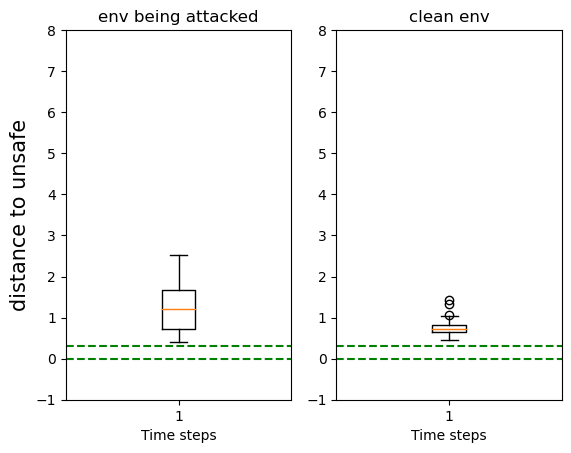

In [49]:
# print((obs_dists_list[0]))

plt.subplot(1, 2, 1)
ave_dist = []
for i in range(50):
#     ave_dist.append(sum(obs_dists_list[i]) / len(obs_dists_list[i]))
    ave_dist.append(min(obs_dists_list[i]))
    # print(obs_dists_list[i])
    # plt.plot(np.arange(len(obs_dists_list[i])), obs_dists_list[i], color='red')
# print(ave_dist)
plt.boxplot(ave_dist)    
plt.ylim((-1, 8))   
plt.axhline(y=0.3, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
plt.ylabel('distance to unsafe', fontsize = 15)
plt.title('env being attacked')
# plt.show()


plt.subplot(1, 2, 2)
ave_dist = []
for i in range(50):
#     ave_dist.append(sum(clean_obs_dists_list[i]) / len(clean_obs_dists_list[i]))
    ave_dist.append(min(clean_obs_dists_list[i]))
    # plt.plot(np.arange(len(clean_obs_dists_list[i])), clean_obs_dists_list[i], color='green')
# print(ave_dist)
plt.boxplot(ave_dist)    
plt.ylim((-1, 8))       
plt.axhline(y=0.3, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
# plt.ylabel('obstacle distance')
plt.title('clean env')
plt.show()

In [27]:
#  train surrogate policy
reached = []
env = bicycleEnv()
# surro_model = A2C.load('A2C_bicycle.zip', env=env)
for k in [30]:
    
    env.k = k
    print('Start training with PPO ...')
    # learning_rate = 1e-3, n_steps = 1024, tune these
    surro_model = PPO("MlpPolicy", env, verbose=0)
    surro_model.learn(total_timesteps=1000000, progress_bar=False)
    vec_env = surro_model.get_env()
    obs = vec_env.reset()
    env = bicycleEnv()
    env.k = 160
    state = env.reset()
    dims0 = []
    dims1 = []
    dims2 = []
    dims3 = []
    euclids = []
    center = [1,1,0,math.sqrt(2)]
    obstacle = [0.5,0.5,0,math.sqrt(2)/2]
    num_reached = 0
    for j in range(1000):
        dim0 = []
        dim1 = []
        dim2 = []
        dim3 = []
        euclid = []
        state = env.reset()
        # Print initial state
        for i in range(30):
            action, _states = surro_model.predict(state, deterministic=True)
            new_state, reward, done, _ = env.step(action)
            dim0.append(state[0])
            dim1.append(state[1])
            dim2.append(state[2])
            dim3.append(state[3])
            dist = np.linalg.norm(new_state-center)
            obs_dist = np.linalg.norm(new_state-obstacle)
            euclid.append(dist)
            state = new_state
            if obs_dist <= env.safe_norm_radius:
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
        dims0.append(dim0)
        dims1.append(dim1)
        dims2.append(dim2)
        dims3.append(dim3)
        euclids.append(euclid)
    reached.append(num_reached)


Start training with A2C ...


In [28]:
# surro_model.save('PPO_bicycle.zip')
# print(reached)

[960]


In [90]:
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint, root

def grey_attack(env, state, model, surro_model, epsilon, policy, norm, args):
    action = surro_model.predict(state, deterministic=True)[0]
    # print(action)
    effect = None
    attack = None
    _action = action
    _state = state
    
    def f(x):
    # Objective function
        return 1
    def fun(x):
        return np.linalg.norm(odeint(bicycle, state, ts, args=(x,))[-1] - env.obstacle) 
    
    x_start = np.array(action)
    lim = [-7, 7]

    bounds = Bounds([lim[0], lim[0]], [lim[1], lim[1]])  

    ts = [env.horizon[env.steps], env.horizon[env.steps+1] ]
    x_state = odeint(bicycle, state, ts, args=(action,))[-1]
    non_linear_eq= lambda x: np.linalg.norm(odeint(bicycle, state, ts, args=(x,))[-1] - env.center) -\
                            np.linalg.norm(odeint(bicycle, state, ts, args=(action,))[-1] - env.center)
    non_linear_constr = NonlinearConstraint(non_linear_eq, - np.inf, 0.0 )
#     result = minimize(f, x_start, method='trust-constr', bounds=bounds, constraints=non_linear_constr)
    result = minimize(fun, x_start, method='trust-constr', bounds=bounds)
    # print(result.x)
    op_action = (result.x)
    state = torch.from_numpy(state)
    
    state = state.detach().unsqueeze(0).requires_grad_(True)
    # print(model.predict(state, deterministic=True)[0])
    next_origin_obs_dist =  np.linalg.norm(odeint(bicycle, _state, ts, args=(_action,))[-1] - env.obstacle)
#     effect = next_origin_obs_dist
    effect = np.linalg.norm(_state - env.obstacle)
    for i in range(100):
     
        action = surro_model.policy(state, deterministic=True)[0].requires_grad_(True)
#         print(action)
#         action = action * 7
        action = action.double()
#         mse = nn.MSELoss()
        
        # compute the distance
        pdist = torch.nn.PairwiseDistance(p=2)
        loss = pdist(torch.tensor([op_action]), action)
        
        # loss = mse(torch.tensor([op_action]).requires_grad_(True), action)
        surro_model.policy.zero_grad()
        loss = loss.double()
        # print(action.dtype)
        loss.backward()
       
        state_grad = state.grad.detach().squeeze()
        perturbed_state = state - epsilon / 30 * state_grad.sign()
        perturbed_state = torch.clamp(perturbed_state, min=torch.from_numpy(_state - 0.5), max=torch.from_numpy(_state + 0.5))

        # print(state_grad)
        # project!
        # print(perturbed_state[0])
        # torch.clamp(perturbed_state, min=(state - epsilon), max=(state + epsilon))
        # print(perturbed_state[0])
        
        scaled_action = surro_model.policy(perturbed_state, deterministic=True)[0]
#         low, high = -7, 7
#         action_next = (low + (0.5 * (scaled_action + 1.0) * (high - low)))
        action_next = scaled_action
        # print(action_next.detach().numpy()
        state = perturbed_state.detach().requires_grad_(True)
        # print(f'state:{perturbed_state}')
    # print(f'action:{_action}, action_pertubed:{action_next}, op_action:{op_action}')
        dist = np.linalg.norm(_state - env.center)
        obs_dist = np.linalg.norm(_state - env.obstacle)
        pertub_dist = np.linalg.norm(state.detach().numpy() - env.center)
        pertub_obs_dist = np.linalg.norm(state.detach().numpy() - env.obstacle)
#         print(action_next)
        next_obs_dist =  np.linalg.norm(odeint(bicycle, state.detach()[0], ts, args=(action_next.detach()[0],))[-1] - env.obstacle)
        if pertub_obs_dist > env.safe_norm_radius and pertub_dist < obs_dist:
            
            if next_obs_dist < effect:
                effect = next_obs_dist
                # print(effect)
                attack = (state.detach().numpy() - _state)[0]
    if attack is None:
        return np.zeros_like(_state)
    else:
        # print('find solution')
        return attack

In [58]:
norm = float('inf')
res_list = []
epsilon = 2
policy = None
args = None
env = bicycleEnv()
model = SAC.load("SAC_bicycle.zip", env=env)
surro_model = PPO.load('PPO_bicycle.zip', env=env)
clean_env = bicycleEnv()
state = env.reset()
dims0 = []
dims1 = []
dims2 = []
euclids = []
obs_dists = []
obs_dists_list = []
dist_list = []
center = [1,1,0,math.sqrt(2)]
obstacle = [0.5,0.5,0,math.sqrt(2)/2]
num_reached = 0
action_list = []
pertub_action_list = [] 
number_violate = 0
clean_obs_dists = []
clean_obs_dists_list = []
clean_num_reached = 0
clean_number_violate = 0
clean_obs_dist_list = []
clean_dist_list = []
for j in range(100):
    dim0 = []
    dim1 = []
    dim2 = []
    euclid = []
    state = env.reset()
    _ = clean_env.reset()
    clean_env.state = state
    clean_state = state
    # print(f'state:{state}, clean_state:{clean_state}')
    # Print initial state
    for i in range(env.step_const):
      
        # action = model.predict(state, deterministic=True)
        # pertub_action = safe_attack(env, state, model, epsilon, policy, norm, args)
        attack = grey_attack(env, state, model, surro_model, epsilon, policy, norm, args)
        # print(attack)
        pertub_state = state + attack
        # print(pertub_state, state)
        pertub_action = model.predict(pertub_state, deterministic=True)[0]
        # print(pertub_action)
        # new_state, reward, done, _ = env.step(pertub_action[0])
        new_state, reward, done, _ = env.step(pertub_action)
        state = new_state
        # new_state, reward, done, _ = env.step(action[0])
        
        dist = np.linalg.norm(state - env.center)
        obs_dist = np.linalg.norm(state - env.obstacle)
        pertub_action_list.append(pertub_action[0])
        # action_list.append(action)
        
        obs_dists.append(obs_dist)
        if obs_dist <= env.safe_norm_radius:
            number_violate += 1
            break
        if dist <= env.target_norm_radius: # stop
            num_reached += 1
            break
        
    # print(obs_dists)
    # print('++++++++++++++++')
    obs_dists_list.append(obs_dists)
    obs_dists = []
    
    # print(env.final_reward_cache)
    # print("dirty env")
    # print(obs_dist_list)
    # print(dist_list)
   
    for i in range(env.step_const):
        clean_action = model.predict(clean_state, deterministic=True)
        clean_new_state, reward, done, _ = clean_env.step(clean_action[0])
        clean_state = clean_new_state
        clean_dist = np.linalg.norm(clean_state - clean_env.center)
        clean_obs_dist = np.linalg.norm(clean_state - clean_env.obstacle)
        # euclid.append(dist)
        
        # clean_obs_dist_list.append(clean_obs_dist)
        clean_dist_list.append(clean_dist)
        clean_obs_dists.append(clean_obs_dist)
        if clean_obs_dist <= env.safe_norm_radius:
            clean_number_violate += 1
            break
        if clean_dist <=  env.target_norm_radius: # stop
            clean_num_reached += 1
            break
    # print(clean_obs_dists)
    # print('-------------------')
    clean_obs_dists_list.append(clean_obs_dists)
    clean_obs_dists = []
    
    # print(clean_env.final_reward_cache)
    # print("clean env")
    # print(clean_obs_dist_list)
    # print(clean_dist_list)
   
    # dims0.append(dim0)
    # dims1.append(dim1)
    # dims2.append(dim2)
    euclids.append(euclid)
ref= [math.pi/2]*30
print("Total number reached = " + str(num_reached))
print("Total number violate = " + str(number_violate))
# print("average of obs dist= " + str(sum(obs_dist_list) / len(obs_dist_list)))
res_list.append(num_reached)
print("clean env for reference")
print("Total number reached = " + str(clean_num_reached))
print("Total number violate = " + str(clean_number_violate))

Total number reached = 34
Total number violate = 0
clean env for reference
Total number reached = 91
Total number violate = 0


In [60]:
class adv_bicycleEnv(gym.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render.modes": ["human"]}

    def __init__(self, render_mode: Optional[str] = None, g=10.0):
        super(bicycleEnv).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        ob_high = np.ones(4)*20
        action_high = np.ones(2)*7
        self.action_space = spaces.Box(low=-action_high, high=action_high, dtype=np.float32)
        self.observation_space = spaces.Box(low=-ob_high, high=ob_high, dtype=np.float32)
        self.step_const = 20
        self.freq = 0.1
        self.steps = 0
        self.center = [1,1,0,math.sqrt(2)]
        self.obstacle = [0.5,0.5,0,math.sqrt(2)/2]
        self.reward_cache = [] # cache distances to target norm ball center
        self.final_reward_cache = [] # cache final reward
        self.state = np.random.rand(4)*2-1
        self.horizon = np.arange(0, self.step_const+2, 1)*0.1
        self.target_norm_radius = 0.8
        self.safe_norm_radius = 0.4
        self.max_reward_list = []
        self.avoid_reward_cache = [] 
        self.quality_list = []
        self.total_steps = 0
        self.step_history = []
        self.k = 20
    def step(self, action):
        terminated = False
        ts = [self.horizon[self.steps], self.horizon[self.steps+1] ]
        self.state = odeint(bicycle, self.state, ts, args=(action,))[-1]
        dist = np.linalg.norm(self.state - self.center)
        obs_dist = np.linalg.norm(self.state - self.obstacle)
#         reward = self.target_norm_radius - dist
        obs_reward = obs_dist - self.safe_norm_radius
        obs_reward = -obs_reward
        # reward = self.target_norm_radius - dist + obs_dist - 0.3
#         self.reward_cache.append(reward)
        self.avoid_reward_cache.append(obs_reward)
#         if self.steps < 10:
#             reach_reward = max(self.reward_cache)
#         else:
#             reach_reward = max(self.reward_cache[-10:])
        if self.steps < 10:
            avoid_reward = min(self.avoid_reward_cache)
        else:
            avoid_reward = min(self.avoid_reward_cache[-10:])    
#         final_reward = min(reach_reward, avoid_reward)
        final_reward =  avoid_reward
        self.reward_cache.append(reward)
        self.steps += 1
        self.total_steps +=1
        # quantitative semantics
        # reach reward, encourage reaching target
        # if self.steps < 10:
        #     reach_reward = max(self.reward_cache)
        # else:
        #     reach_reward = max(self.reward_cache[-10:])
        # final_reward = reach_reward
        if dist <= self.target_norm_radius:
            final_reward = 10
        self.final_reward_cache.append(final_reward)
        if self.steps == self.step_const or max(np.absolute(self.state))>20 or obs_dist<=self.safe_norm_radius:
            self.max_reward_list.append(max(self.final_reward_cache)) # use max final reward to measure episodes
            self.step_history.append(self.total_steps)
            self.quality_list.append(sum(self.final_reward_cache))
            terminated = True
            self.reset()

        # Return next state, reward, done, info
        return self.state, final_reward, terminated, {}

    def reset(self):
        self.steps = 0
        # self.state = np.random.rand(4)*2-1
        self.state = np.random.rand(4)*2-1.2
        self.reward_cache = []
        self.step_const = self.k
        self.horizon = np.arange(0, self.step_const+2, 1)*0.1
        self.final_reward_cache = []
        return self.state  # reward, done, info can't be included

    def render(self, mode="human"):
        return

    def close(self):
        if self.screen is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [79]:
#  train adv policy
reached = []
env = adv_bicycleEnv()
# adv_model = SAC.load('adv_SAC_bicycle.zip', env=env)
for k in [30]:
    
    env.k = k
    print('Start training with SAC ...')
    # learning_rate = 1e-3, n_steps = 1024, tune these
    adv_model = SAC("MlpPolicy", env, verbose=0)
    adv_model.learn(total_timesteps=300000, progress_bar=False)
    vec_env = adv_model.get_env()
    obs = vec_env.reset()
#     env = adv_bicycleEnv()
    env.k = 160
    state = env.reset()
#     dims0 = []
#     dims1 = []
#     dims2 = []
#     dims3 = []
#     euclids = []
    center = [1,1,0,math.sqrt(2)]
    obstacle = [0.5,0.5,0,math.sqrt(2)/2]
    num_reached = 0
    for j in range(1000):
#         dim0 = []
#         dim1 = []
#         dim2 = []
#         dim3 = []
#         euclid = []
        state = env.reset()
        # Print initial state
        for i in range(30):
            action, _states = adv_model.predict(state, deterministic=True)
            new_state, reward, done, _ = env.step(action)
#             dim0.append(state[0])
#             dim1.append(state[1])
#             dim2.append(state[2])
#             dim3.append(state[3])
            dist = np.linalg.norm(new_state-center)
            obs_dist = np.linalg.norm(new_state-obstacle)
#             euclid.append(dist)
            state = new_state
            if obs_dist <= env.safe_norm_radius:
                break
#             if dist <= env.target_norm_radius: # stop
#                 num_reached += 1
#                 break
#         dims0.append(dim0)
#         dims1.append(dim1)
#         dims2.append(dim2)
#         dims3.append(dim3)
#         euclids.append(euclid)
    reached.append(num_reached)


C:\Users\sjian\anaconda3\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
C:\Users\sjian\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Start training with SAC ...


In [80]:
adv_model.save('adv_SAC_bicycle.zip')

In [63]:
print(num_reached)

885


In [91]:

def black_attack(env, state, model, surro_model,adv_model, epsilon, policy, norm, args):
    action = surro_model.predict(state, deterministic=True)[0]
    # print(action)
    effect = None
    attack = None
    _action = action
    _state = state
    
    x_start = np.array(action)
    lim = [-7, 7]

    bounds = Bounds([lim[0], lim[0]], [lim[1], lim[1]])  

    ts = [env.horizon[env.steps], env.horizon[env.steps+1] ]
#     x_state = odeint(bicycle, state, ts, args=(action,))[-1]
    
    # print(result.x)
    op_action = adv_model.predict(state)[0]
    state = torch.from_numpy(state)
    
    state = state.detach().unsqueeze(0).requires_grad_(True)
    # print(model.predict(state, deterministic=True)[0])
    next_origin_obs_dist =  np.linalg.norm(odeint(bicycle, _state, ts, args=(_action,))[-1] - env.obstacle)
#     effect = next_origin_obs_dist
    effect = np.linalg.norm(_state - env.obstacle)
    for i in range(100):
     
        action = surro_model.policy(state, deterministic=True)[0].requires_grad_(True)
#         print(action)
#         action = action * 7
        action = action.double()
#         mse = nn.MSELoss()
        
        # compute the distance
        pdist = torch.nn.PairwiseDistance(p=2)
        loss = pdist(torch.tensor([op_action]), action)
        
        # loss = mse(torch.tensor([op_action]).requires_grad_(True), action)
        surro_model.policy.zero_grad()
        loss = loss.double()
        # print(action.dtype)
        loss.backward()
       
        state_grad = state.grad.detach().squeeze()
        perturbed_state = state - epsilon / 30 * state_grad.sign()
        perturbed_state = torch.clamp(perturbed_state, min=torch.from_numpy(_state - 0.5), max=torch.from_numpy(_state + 0.5))

        # print(state_grad)
        # project!
        # print(perturbed_state[0])
        # torch.clamp(perturbed_state, min=(state - epsilon), max=(state + epsilon))
        # print(perturbed_state[0])
        
        scaled_action = surro_model.policy(perturbed_state, deterministic=True)[0]
#         low, high = -7, 7
#         action_next = (low + (0.5 * (scaled_action + 1.0) * (high - low)))
        action_next = scaled_action
        # print(action_next.detach().numpy()
        state = perturbed_state.detach().requires_grad_(True)
        # print(f'state:{perturbed_state}')
    # print(f'action:{_action}, action_pertubed:{action_next}, op_action:{op_action}')
        dist = np.linalg.norm(_state - env.center)
        obs_dist = np.linalg.norm(_state - env.obstacle)
        pertub_dist = np.linalg.norm(state.detach().numpy() - env.center)
        pertub_obs_dist = np.linalg.norm(state.detach().numpy() - env.obstacle)
#         print(action_next)
        next_obs_dist =  np.linalg.norm(odeint(bicycle, state.detach()[0], ts, args=(action_next.detach()[0],))[-1] - env.obstacle)
        if pertub_obs_dist > env.safe_norm_radius and pertub_dist < obs_dist:
            
            if next_obs_dist < effect:
                effect = next_obs_dist
                # print(effect)
                attack = (state.detach().numpy() - _state)[0]
    if attack is None:
        return np.zeros_like(_state)
    else:
        # print('find solution')
        return attack

In [92]:

# test white, grey, black box attack
norm = float('inf')
res_list = []
epsilon = 2
policy = None
args = None
env = bicycleEnv()
adv_env = adv_bicycleEnv()
model = SAC.load("SAC_bicycle.zip", env=env)
surro_model = PPO.load('PPO_bicycle.zip', env=env)
adv_model = SAC.load('adv_SAC_bicycle.zip', env=adv_env)
clean_env = bicycleEnv()
black_env = bicycleEnv()
white_env = bicycleEnv()
grey_env = bicycleEnv()
all_envs = [clean_env, white_env, grey_env, black_env]
state = env.reset()

# obs_dists = []
# obs_dists_list = []
# dist_list = []
center = env.center
obstacle =  env.obstacle
# num_reached = 0
# action_list = []
# pertub_action_list = [] 
# number_violate = 0
clean_obs_dists = []
clean_obs_dists_list = []
clean_num_reached = 0
clean_number_violate = 0
clean_obs_dist_list = []
clean_dist_list = []
black_obs_dists = []
black_obs_dists_list = []
black_num_reached = 0
black_number_violate = 0
black_obs_dist_list = []
black_dist_list = []
grey_obs_dists = []
grey_obs_dist_list = []
grey_num_reached = 0
grey_number_violate = 0
grey_obs_dists_list = []
grey_dist_list = []
white_obs_dists = []
white_obs_dists_list = []
white_num_reached = 0
white_number_violate = 0
white_obs_dist_list = []
white_dist_list = []


for j in range(100):
    _ = [env.reset() for env in all_envs]
    for env in all_envs:
        env.state = clean_env.state
    
# black-box
    state = black_env.state
    for i in range(env.step_const):
        
        attack = black_attack(black_env, state, model, surro_model,adv_model, epsilon, policy, norm, args)
#         print(f'black_attack:{attack}')
        pertub_state = state + attack
        pertub_action = model.predict(pertub_state, deterministic=True)[0]
        new_state, reward, done, _ = black_env.step(pertub_action)
        state = new_state        
        dist = np.linalg.norm(state - black_env.center)
        obs_dist = np.linalg.norm(state - black_env.obstacle)
#         pertub_action_list.append(pertub_action[0])
        # action_list.append(action)
        
        black_obs_dists.append(obs_dist)
        if obs_dist <= black_env.safe_norm_radius:
            black_number_violate += 1
            break
        if dist <= black_env.target_norm_radius: # stop
            black_num_reached += 1
            break
        
    # print(obs_dists)
    # print('++++++++++++++++')
    black_obs_dists_list.append(black_obs_dists)
    black_obs_dists = []
    
# grey-box
    state = grey_env.state
    for i in range(env.step_const):
        
        attack = grey_attack(grey_env, state, model, surro_model, epsilon, policy, norm, args)
#         print(f'grey_attack:{attack}')
        pertub_state = state + attack
        pertub_action = model.predict(pertub_state, deterministic=True)[0]
        new_state, reward, done, _ = grey_env.step(pertub_action)
        state = new_state        
        dist = np.linalg.norm(state - grey_env.center)
        obs_dist = np.linalg.norm(state - grey_env.obstacle)
        
        grey_obs_dists.append(obs_dist)
        if obs_dist <= grey_env.safe_norm_radius:
            grey_number_violate += 1
            break
        if dist <= grey_env.target_norm_radius: # stop
            grey_num_reached += 1
            break
        
    # print(obs_dists)
    # print('++++++++++++++++')
    grey_obs_dists_list.append(grey_obs_dists)
    grey_obs_dists = []
    
    
# white
    state = white_env.state
    for i in range(env.step_const):
        
        attack = safe_attack(white_env, state, model, epsilon, policy, norm, args)
#         print(attack)
        pertub_state = state + attack
        pertub_action = model.predict(pertub_state, deterministic=True)[0]
        new_state, reward, done, _ = white_env.step(pertub_action)
        state = new_state        
        dist = np.linalg.norm(state - white_env.center)
        obs_dist = np.linalg.norm(state - white_env.obstacle)
        
        white_obs_dists.append(obs_dist)
        if obs_dist <= white_env.safe_norm_radius:
            white_number_violate += 1
            break
        if dist <= white_env.target_norm_radius: # stop
            white_num_reached += 1
            break
        
    # print(obs_dists)
    # print('++++++++++++++++')
    white_obs_dists_list.append(white_obs_dists)
    white_obs_dists = []

#    clean env
    clean_state = clean_env.state
    for i in range(env.step_const):
        clean_action = model.predict(clean_state, deterministic=True)
        clean_new_state, reward, done, _ = clean_env.step(clean_action[0])
        clean_state = clean_new_state
        clean_dist = np.linalg.norm(clean_state - clean_env.center)
        clean_obs_dist = np.linalg.norm(clean_state - clean_env.obstacle)
        # euclid.append(dist)
        
        # clean_obs_dist_list.append(clean_obs_dist)
        clean_dist_list.append(clean_dist)
        clean_obs_dists.append(clean_obs_dist)
        if clean_obs_dist <= env.safe_norm_radius:
            clean_number_violate += 1
            break
        if clean_dist <=  env.target_norm_radius: # stop
            clean_num_reached += 1
            break
    # print(clean_obs_dists)
    # print('-------------------')
    clean_obs_dists_list.append(clean_obs_dists)
    clean_obs_dists = []

ref= [math.pi/2]*30
print("black env for reference")
print("Total number reached = " + str(black_num_reached))
print("Total number violate = " + str(black_number_violate))
# print("average of obs dist= " + str(sum(obs_dist_list) / len(obs_dist_list)))


# print("average of obs dist= " + str(sum(clean_obs_dist_list) / len(clean_obs_dist_list)))
print("grey env for reference")
print("Total number reached = " + str(grey_num_reached))
print("Total number violate = " + str(grey_number_violate))
print("white env for reference")
print("Total number reached = " + str(white_num_reached))
print("Total number violate = " + str(white_number_violate))
print("clean env for reference")
print("Total number reached = " + str(clean_num_reached))
print("Total number violate = " + str(clean_number_violate))

C:\Users\sjian\anaconda3\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
C:\Users\sjian\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
C:\Users\sjian\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


black env for reference
Total number reached = 71
Total number violate = 0
grey env for reference
Total number reached = 61
Total number violate = 1
white env for reference
Total number reached = 24
Total number violate = 0
clean env for reference
Total number reached = 92
Total number violate = 0


([<matplotlib.axis.XTick at 0x20980b722c0>,
 [Text(1, 0, 'white'),
  Text(2, 0, 'grey'),
  Text(3, 0, 'black'),
  Text(4, 0, 'clean')])

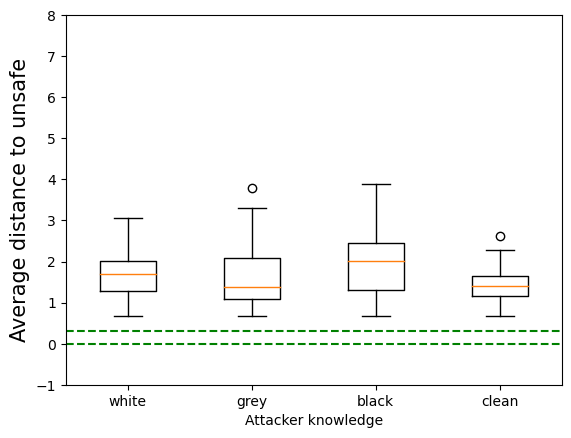

In [88]:
label = ['white', 'grey', 'black', 'clean']
black = []
white = []
grey = []
clean = []
for i in range(100):
    black.append(sum(black_obs_dists_list[i]) / len(black_obs_dists_list[i]))
    white.append(sum(white_obs_dists_list[i]) / len(white_obs_dists_list[i]))
    grey.append(sum(grey_obs_dists_list[i]) / len(grey_obs_dists_list[i]))
    clean.append(sum(clean_obs_dists_list[i]) / len(clean_obs_dists_list[i]))
#     black.append(min(black_obs_dists_list[i]) )
#     white.append(min(white_obs_dists_list[i]))
#     grey.append(min(grey_obs_dists_list[i]))
#     clean.append(min(clean_obs_dists_list[i]))
data = [white, grey, black, clean]
ax = plt.boxplot(data)    
plt.ylim((-1, 8))   
plt.axhline(y=0.3, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Attacker knowledge')
plt.ylabel('Average distance to unsafe', fontsize = 15)
# plt.title('Average distance to unsafe')
plt.xticks([1, 2, 3, 4], label)
# plt.legend([ax["boxes"][0], ax["boxes"][1]], ['white', 'grey'], loc='upper right')
# plt.show()
